# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score
from sklearn.svm import SVC
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression

pd.options.mode.chained_assignment = None
%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Profile Processing

In [2]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [3]:
# Replace customer id to match transcript
profile.rename(columns={'id': 'customer_id'}, inplace=True)

In [4]:
# Replace all None value to NaN
profile = profile.fillna(value=np.nan)

In [5]:
# Check NaN percentage on columns
profile.isna().mean()

gender              0.127941
age                 0.000000
customer_id         0.000000
became_member_on    0.000000
income              0.127941
dtype: float64

In [6]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [7]:
# Checking duplicate data on any columns
profile.columns.duplicated().sum()

0

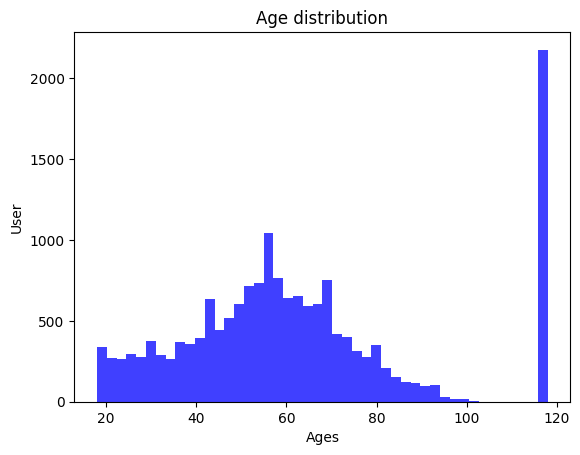

In [8]:
sns.histplot(profile['age'], color='blue', linewidth=0)
plt.title('Age distribution')
plt.xlabel('Ages')
plt.ylabel('User');

In [9]:
# Checking age to find outlier number
profile.groupby('age')['customer_id'].value_counts()

age  customer_id                     
18   0454292436bd4cee98e8ec873e30433e    1
     079bc7a16fe94907911fcac3b93754d5    1
     095bc1a9b5f64d0f88ed616df292a3ec    1
     13e0d788744c413e99fe60f4f571233b    1
     13f95724ed4042aaa8953e8ed5d073c9    1
                                        ..
118  ff71a5ae9c964d4195f69d15cd2aceeb    1
     ff726a9e9f8643ee9ae1c7b074a583dc    1
     ff964fce42a74d519bd1ad2e0e20cd9e    1
     ffecb1f8543f4bf7bade023de366d6bf    1
     ffede3b700ac41d6a266fa1ba74b4f16    1
Name: customer_id, Length: 17000, dtype: int64

In [10]:
# Count records with age 118 (unrealistic)
profile[profile['age'] == 118].shape[0]

2175

In [11]:
# check all feature on records with age 118
profile[profile['age'] == 118].head()

,gender,age,customer_id,became_member_on,income
0,NaN,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
2,NaN,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
4,NaN,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
6,NaN,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,NaN,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN


In [12]:
# percentage of records with age 118 on total records
ratio = profile[profile['age'] == 118].shape[0]/profile.shape[0]
print(ratio)

0.12794117647058822


In [13]:
profile[profile['age'] == 118].count()

gender                 0
age                 2175
customer_id         2175
became_member_on    2175
income                 0
dtype: int64

In [14]:
# Count total gender
profile['gender'].value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

Text(0, 0.5, 'Gender')

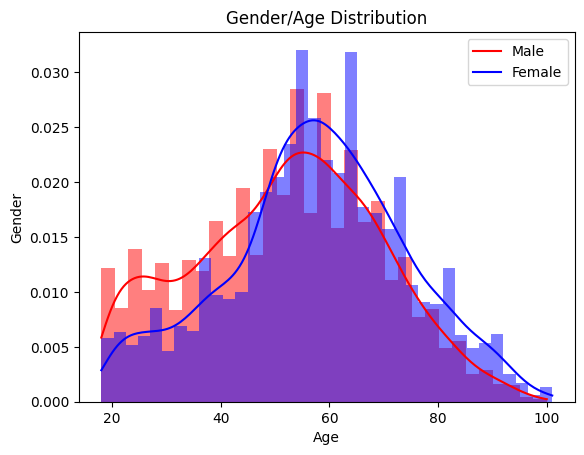

In [15]:
# Gender/Age distribution
sns.histplot(profile[profile['gender'] == 'M']['age'], color='red', label='Male', kde=True, stat='density', linewidth=0)
sns.histplot(profile[profile['gender'] == 'F']['age'], color='blue', label='Female', kde=True, stat='density', linewidth=0)
plt.legend(['Male', 'Female'])
plt.title('Gender/Age Distribution')
plt.xlabel('Age')
plt.ylabel('Gender')

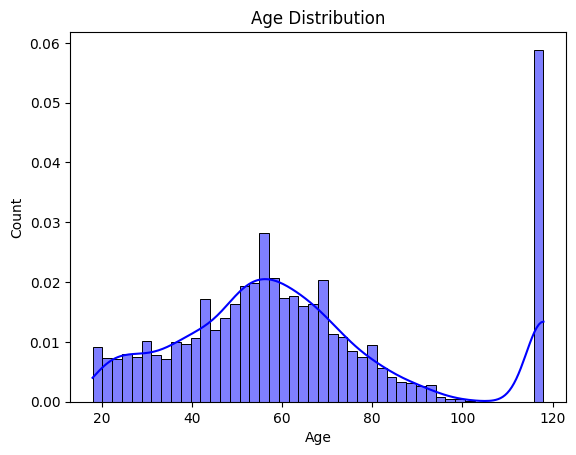

In [16]:
# View distribution of each age
sns.histplot(profile['age'], color='blue', label='Age', kde=True, stat='density')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count');

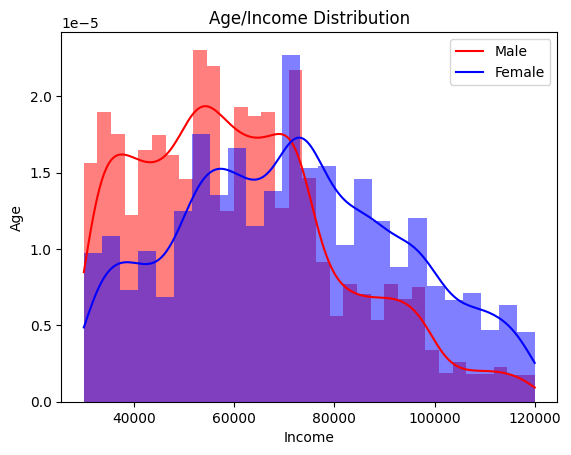

In [17]:
# View distribution of gender and income
sns.histplot(profile[profile['gender'] == 'M']['income'], color='red', label='Male', kde=True, stat='density', linewidth=0)
sns.histplot(profile[profile['gender'] == 'F']['income'], color='blue', label='Female', kde=True, stat='density', linewidth=0)
plt.title('Age/Income Distribution')
plt.legend(['Male', 'Female'])
plt.xlabel('Income')
plt.ylabel('Age');

In [18]:
# Convert became_member_on to datetime
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')
# One-Hot Encoding for gender
genders = pd.get_dummies(profile['gender'], prefix='gender', prefix_sep='_')
profile = pd.concat([profile, genders], axis=1)
# Change user with age 118 to NaN
profile['age'] = profile['age'].apply(lambda x: np.nan if x == 118 else x)
# Get number days user become member
today = pd.to_datetime(datetime.today().strftime('%Y%m%d'))
profile['became_member_on'] = (today - profile['became_member_on']) / np.timedelta64(1, 'D')

In [19]:
profile.head()

,gender,age,customer_id,became_member_on,income,gender_F,gender_M,gender_O
0,NaN,NaN,68be06ca386d4c31939f3a4f0e3dd783,2103.0,NaN,0,0,0
1,F,55.0,0610b486422d4921ae7d2bf64640c50b,1950.0,112000.0,1,0,0
2,NaN,NaN,38fe809add3b4fcf9315a9694bb96ff5,1588.0,NaN,0,0,0
3,F,75.0,78afa995795e4d85b5d9ceeca43f5fef,2017.0,100000.0,1,0,0
4,NaN,NaN,a03223e636434f42ac4c3df47e8bac43,1930.0,NaN,0,0,0


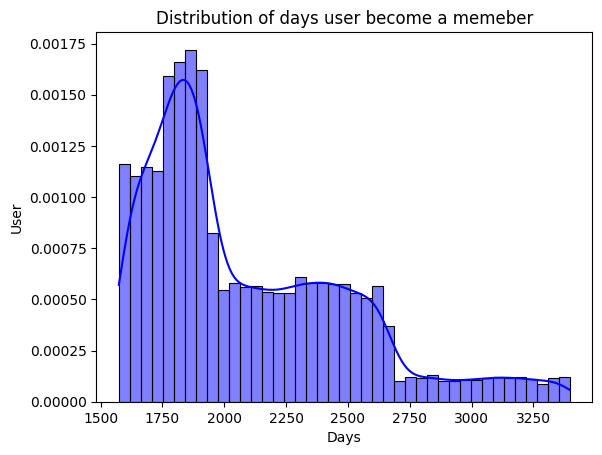

In [20]:
sns.histplot(profile['became_member_on'], color='blue', kde=True, stat='density')
plt.title('Distribution of days user become a memeber')
plt.xlabel('Days')
plt.ylabel('User');

## Portfolio Processing

In [21]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [22]:
portfolio = portfolio.fillna(value=np.nan)

In [23]:
# Check NaN percentage on columns
portfolio.isna().mean()

reward        0.0
channels      0.0
difficulty    0.0
duration      0.0
offer_type    0.0
id            0.0
dtype: float64

In [24]:
# Checking duplicate data on any columns
portfolio.columns.duplicated().sum()

0

In [25]:
# One-Hot Encoding on channels
portfolio['email'] = portfolio['channels'].apply(lambda x: 1 if 'email' in x else 0)
portfolio['mobile'] = portfolio['channels'].apply(lambda x: 1 if 'mobile' in x else 0)
portfolio['social'] = portfolio['channels'].apply(lambda x: 1 if 'social' in x else 0)
portfolio['web'] = portfolio['channels'].apply(lambda x: 1 if 'web' in x else 0)
# One-Hot Encoding on offer-type
offer_types = pd.get_dummies(portfolio['offer_type'], prefix ='offer_type', prefix_sep='_')
portfolio = pd.concat([portfolio.drop(['offer_type','channels'], axis=1), offer_types], axis=1)
# Rename id to match transaction
portfolio.rename(columns={'id':'offer_id'}, inplace=True)

In [26]:
portfolio.head()

,reward,difficulty,duration,offer_id,email,mobile,social,web,offer_type_bogo,offer_type_discount,offer_type_informational
0,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,1,0,0
1,10,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0
2,0,0,4,3f207df678b143eea3cee63160fa8bed,1,1,0,1,0,0,1
3,5,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1,1,0,0
4,5,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1,0,1,0


## Transcript Processing

In [27]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [28]:
# Extract offer_id from json data value
transcript['offer_id'] = transcript['value'].apply(lambda x: x['offer_id'] if 'offer_id' in x else (x['offer id'] if 'offer id' in x else None))
# Extract reward from json data value
transcript['reward'] = transcript['value'].apply(lambda x:x['reward'] if 'reward' in x else None)
# Extract amount from json data value
transcript['amount'] = transcript['value'].apply(lambda x:x['amount'] if 'amount' in x else None)
# Drop unused column
transcript.drop('value', axis=1, inplace=True)
# Rename person to match portfolio
transcript.rename(columns={'person':'customer_id'}, inplace=True)
# Convert time to number of days
transcript['time'] = transcript['time'] / 24
transcript.head()

,customer_id,event,time,offer_id,reward,amount
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0.0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0.0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0.0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN


In [29]:
# Replace all None value to NaN
transcript = transcript.fillna(value=np.nan)

In [30]:
# Check NaN percentage on columns
transcript.isna().mean()

customer_id    0.000000
event          0.000000
time           0.000000
offer_id       0.453304
reward         0.890456
amount         0.546696
dtype: float64

In [31]:
# Group offer by event and customer
offer_status = transcript.groupby(['customer_id', 'offer_id', 'event'])['time'].count().unstack()
offer_status.reset_index(level=[0,1], inplace=True)
# Fill value 0.0 back to NaN
offer_status.fillna(0.0, inplace=True)
# Extract complete offer
offer_status['complete_offer'] = offer_status['offer completed'] * offer_status['offer viewed']
offer_status['complete_offer'] = offer_status['complete_offer'].apply(lambda x: 1.0 if x > 0 else 0.0)
# Drop unused columns
offer_status.drop(['offer completed','offer viewed','offer received'], axis=1, inplace = True)
transcript = offer_status
transcript.head(10)

event,customer_id,offer_id,complete_offer
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,0.0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0.0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,0.0
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1.0
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1.0
5,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,0.0
6,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,1.0
7,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,1.0
8,0011e0d4e6b944f998e987f904e8c1e5,3f207df678b143eea3cee63160fa8bed,0.0
9,0011e0d4e6b944f998e987f904e8c1e5,5a8bc65990b245e5a138643cd4eb9837,0.0


## Data Analysis & Visualization

In [32]:
# Merge 3 dataframe into unified data frame
unified_df = transcript.merge(portfolio, how='left', on='offer_id')
unified_df = unified_df.merge(profile, how='left', on='customer_id')
unified_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63288 entries, 0 to 63287
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               63288 non-null  object 
 1   offer_id                  63288 non-null  object 
 2   complete_offer            63288 non-null  float64
 3   reward                    63288 non-null  int64  
 4   difficulty                63288 non-null  int64  
 5   duration                  63288 non-null  int64  
 6   email                     63288 non-null  int64  
 7   mobile                    63288 non-null  int64  
 8   social                    63288 non-null  int64  
 9   web                       63288 non-null  int64  
 10  offer_type_bogo           63288 non-null  uint8  
 11  offer_type_discount       63288 non-null  uint8  
 12  offer_type_informational  63288 non-null  uint8  
 13  gender                    55222 non-null  object 
 14  age   

In [33]:
# Change offer_id to type
unique_ids = list(unified_df['offer_id'].unique())
for i in range(len(unique_ids)):
    unified_df['offer_id'] = unified_df['offer_id'].apply(lambda x: 'type_{0}'.format(str(i+1)) if x == unique_ids[i] else x)
unified_df.head(10)

,customer_id,offer_id,complete_offer,reward,difficulty,duration,email,mobile,social,web,offer_type_bogo,offer_type_discount,offer_type_informational,gender,age,became_member_on,income,gender_F,gender_M,gender_O
0,0009655768c64bdeb2e877511632db8f,type_1,0.0,2,10,7,1,1,0,1,0,1,0,M,33.0,2035.0,72000.0,0,1,0
1,0009655768c64bdeb2e877511632db8f,type_2,0.0,0,0,4,1,1,0,1,0,0,1,M,33.0,2035.0,72000.0,0,1,0
2,0009655768c64bdeb2e877511632db8f,type_3,0.0,0,0,3,1,1,1,0,0,0,1,M,33.0,2035.0,72000.0,0,1,0
3,0009655768c64bdeb2e877511632db8f,type_4,1.0,5,5,5,1,1,1,1,1,0,0,M,33.0,2035.0,72000.0,0,1,0
4,0009655768c64bdeb2e877511632db8f,type_5,1.0,2,10,10,1,1,1,1,0,1,0,M,33.0,2035.0,72000.0,0,1,0
5,00116118485d4dfda04fdbaba9a87b5c,type_4,0.0,5,5,5,1,1,1,1,1,0,0,NaN,NaN,1666.0,NaN,0,0,0
6,0011e0d4e6b944f998e987f904e8c1e5,type_6,1.0,5,20,10,1,0,0,1,0,1,0,O,40.0,1772.0,57000.0,0,0,1
7,0011e0d4e6b944f998e987f904e8c1e5,type_7,1.0,3,7,7,1,1,1,1,0,1,0,O,40.0,1772.0,57000.0,0,0,1
8,0011e0d4e6b944f998e987f904e8c1e5,type_2,0.0,0,0,4,1,1,0,1,0,0,1,O,40.0,1772.0,57000.0,0,0,1
9,0011e0d4e6b944f998e987f904e8c1e5,type_3,0.0,0,0,3,1,1,1,0,0,0,1,O,40.0,1772.0,57000.0,0,0,1


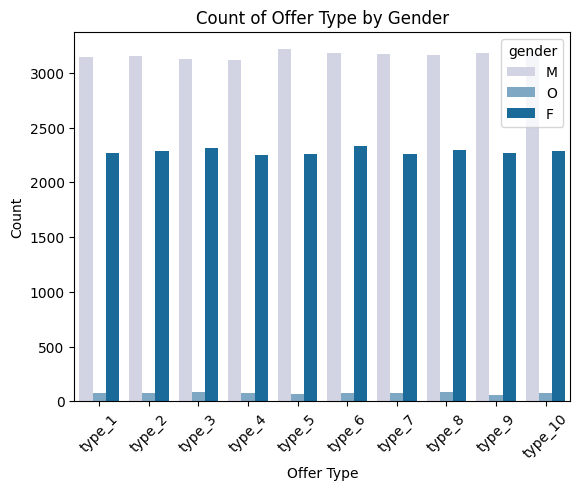

In [34]:
sns.countplot(x='offer_id', hue='gender', data=unified_df, palette='PuBu')
plt.title('Count of Offer Type by Gender')
plt.xlabel('Offer Type')
plt.ylabel('Count')
plt.xticks(rotation=45);

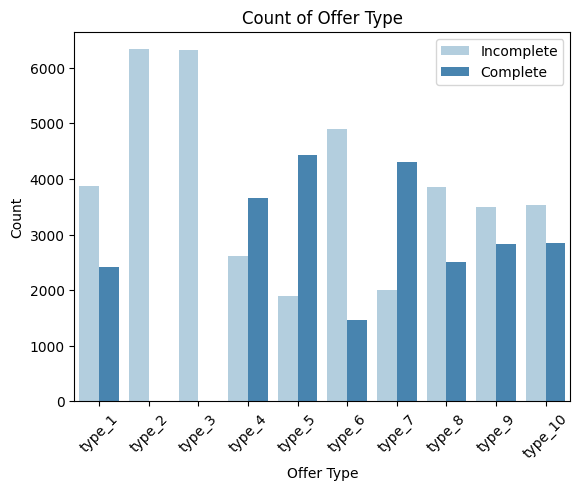

In [35]:
sns.countplot(x='offer_id', hue='complete_offer', data=unified_df, palette='Blues')
plt.legend(['Incomplete', 'Complete'])
plt.title('Count of Offer Type')
plt.xlabel('Offer Type')
plt.ylabel('Count')
plt.xticks(rotation=45);

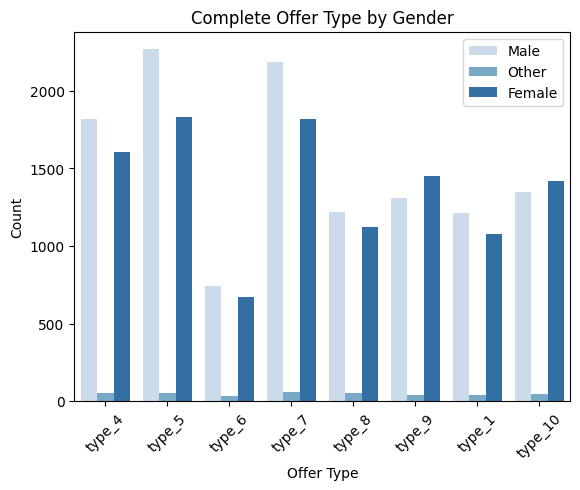

In [36]:
sns.countplot(x='offer_id',hue='gender',data=unified_df[unified_df['complete_offer'] == 1], palette='Blues')
plt.legend(['Male', 'Other', 'Female'])
plt.title('Complete Offer Type by Gender')
plt.xlabel('Offer Type')
plt.ylabel('Count')
plt.xticks(rotation=45);

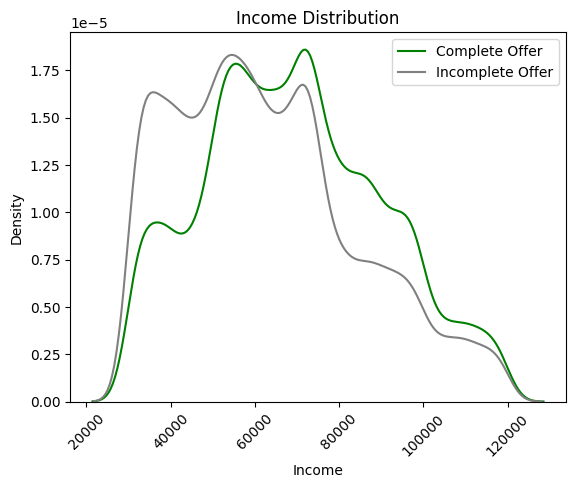

In [37]:
#Distribution of income if offer was successful
sns.kdeplot(unified_df[unified_df['complete_offer'] == 1]['income'], color='green')
sns.kdeplot(unified_df[unified_df['complete_offer'] == 0]['income'], color='grey')
plt.legend(['Complete Offer', 'Incomplete Offer'])
plt.xlabel('Income')
plt.ylabel('Density')
plt.title('Income Distribution')
plt.xticks(rotation=45);

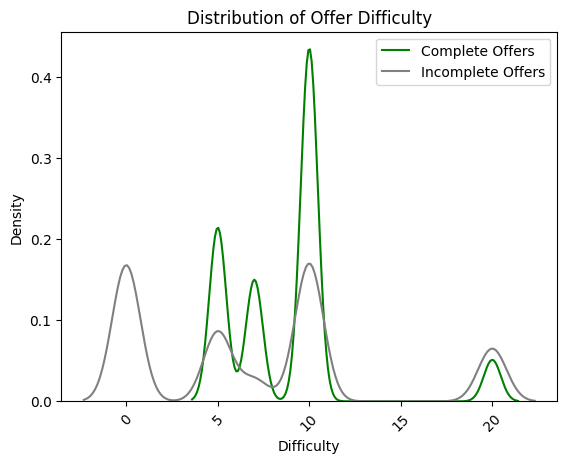

In [38]:
# Distribution of difficulty on total offer
sns.kdeplot(unified_df[unified_df['complete_offer'] == 1]['difficulty'], color='green')
sns.kdeplot(unified_df[unified_df['complete_offer'] == 0]['difficulty'], color='grey')
plt.legend(['Complete Offers', 'Incomplete Offers'])
plt.title('Distribution of Offer Difficulty')
plt.xlabel('Difficulty')
plt.ylabel('Density')
plt.xticks(rotation=45);

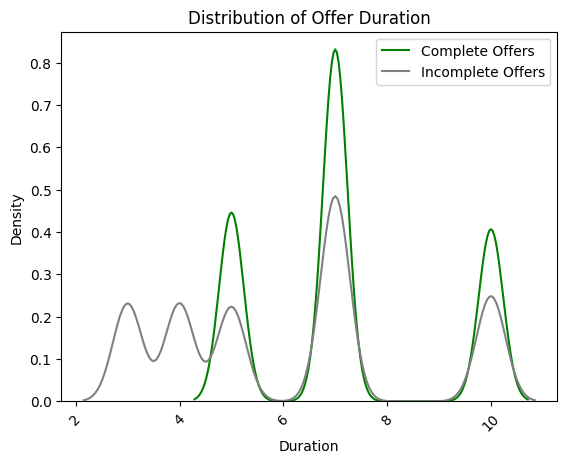

In [39]:
# Distribution of duration on total offer
sns.kdeplot(unified_df[unified_df['complete_offer'] == 1]['duration'], color='green')
sns.kdeplot(unified_df[unified_df['complete_offer'] == 0]['duration'], color='grey')
plt.legend(['Complete Offers','Incomplete Offers'])
plt.title('Distribution of Offer Duration')
plt.xlabel('Duration')
plt.ylabel('Density')
plt.xticks(rotation=45);

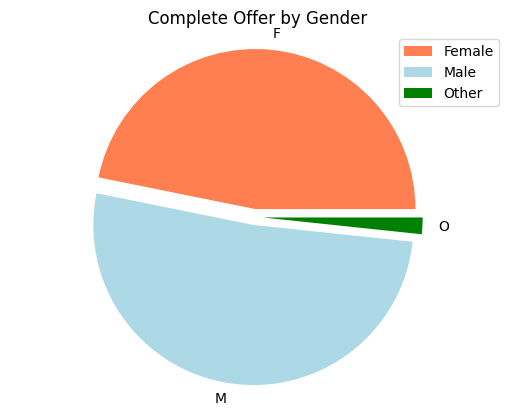

In [40]:
complete_sum_offer = unified_df.groupby(['gender'])['complete_offer'].sum()
plt.pie(complete_sum_offer, labels=complete_sum_offer.index, explode = (0.05,0.05,0.05), colors=['coral','lightblue','green'])
plt.legend(['Female', 'Male', 'Other'])
plt.title('Complete Offer by Gender')
plt.gca().axis('Equal');

## Modeling

### Random Forrest Classifier

In [41]:
# Get complete offer as predicted outcome
df_complete = unified_df[unified_df['complete_offer'] == 1]
# Gender has ben One-Hot Encoding, it's safe to remove it
df_complete.drop('gender', axis=1, inplace=True)

In [42]:
# Replace NaN value by Mean values
df_complete['age'] = df_complete['age'].fillna(df_complete['age'].mean())
df_complete['income'] = df_complete['age'].fillna(df_complete['income'].mean())

In [43]:
df_complete.isnull().sum()

customer_id                 0
offer_id                    0
complete_offer              0
reward                      0
difficulty                  0
duration                    0
email                       0
mobile                      0
social                      0
web                         0
offer_type_bogo             0
offer_type_discount         0
offer_type_informational    0
age                         0
became_member_on            0
income                      0
gender_F                    0
gender_M                    0
gender_O                    0
dtype: int64

In [44]:
# Train data, exclued id columns, offer columns, only store user data
X = df_complete.iloc[:, 13:]
# Test data suggest offer id
Y = df_complete.iloc[:,1]
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.25, random_state=21)
X_train.shape, X_test.shape

((18345, 6), (6115, 6))

In [45]:
# Feature scaling
scaler = StandardScaler()
X_train= scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
clf = RandomForestClassifier(n_estimators=20, criterion='entropy', random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=20, random_state=42)

In [46]:
y_pred = clf.predict(X_test)

In [47]:
accuracy_score(y_test, y_pred)

0.08536385936222404

In [48]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      type_1       0.04      0.04      0.04       607
     type_10       0.08      0.08      0.08       691
      type_4       0.09      0.09      0.09       921
      type_5       0.13      0.12      0.12      1145
      type_6       0.04      0.04      0.04       358
      type_7       0.12      0.13      0.12      1070
      type_8       0.05      0.05      0.05       612
      type_9       0.06      0.06      0.06       711

    accuracy                           0.09      6115
   macro avg       0.08      0.08      0.08      6115
weighted avg       0.09      0.09      0.09      6115



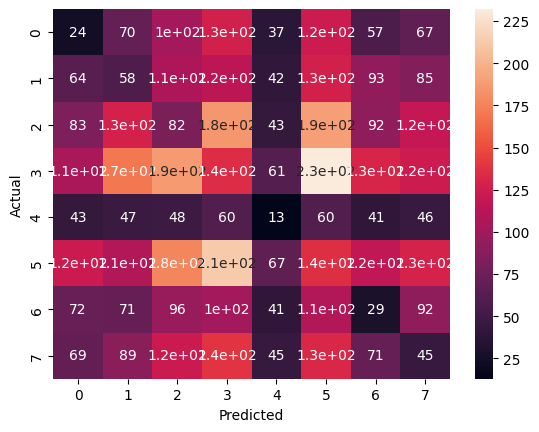

In [49]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual');

### Logistic Regression

<AxesSubplot: >

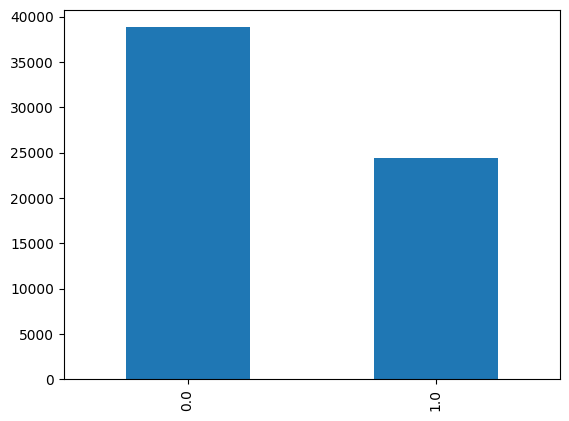

In [50]:
unified_df['complete_offer'].value_counts().plot(kind='bar')

In [51]:
# Balance dataset by random over-sampling by random datapoints from complete offers
df_complete = unified_df.loc[unified_df['complete_offer'] == 1]
count_type_0,count_type_1 = unified_df['complete_offer'].value_counts()
# Concat new sample data point to default dataset
new_df = pd.concat([df_complete.sample(count_type_0, replace=True), unified_df.loc[unified_df['complete_offer'] == 0]], axis=0)
# Drop gender due to One-Hot Encoding already
new_df.drop('gender', axis=1, inplace=True)

In [52]:
new_df['complete_offer'].value_counts()

1.0    38828
0.0    38828
Name: complete_offer, dtype: int64

In [53]:
new_df.isnull().sum()

customer_id                    0
offer_id                       0
complete_offer                 0
reward                         0
difficulty                     0
duration                       0
email                          0
mobile                         0
social                         0
web                            0
offer_type_bogo                0
offer_type_discount            0
offer_type_informational       0
age                         8678
became_member_on               0
income                      8678
gender_F                       0
gender_M                       0
gender_O                       0
dtype: int64

In [54]:
# Replace NaN value to Median value
new_df['age'] = new_df['age'].fillna(new_df['age'].median())
new_df['income'] = new_df['income'].fillna(new_df['income'].median())

In [55]:
X = new_df.iloc[:,3:]
y = new_df.iloc[:,2]
# Add offer_id to our new dataframe
X = pd.concat([X, new_df['offer_id']], axis=1)

In [56]:
# One-Hot Encoding offer_id
X = pd.concat([X.drop('offer_id', axis=1), pd.get_dummies(X['offer_id'])], axis=1)

In [57]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77656 entries, 462 to 63281
Data columns (total 26 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   reward                    77656 non-null  int64  
 1   difficulty                77656 non-null  int64  
 2   duration                  77656 non-null  int64  
 3   email                     77656 non-null  int64  
 4   mobile                    77656 non-null  int64  
 5   social                    77656 non-null  int64  
 6   web                       77656 non-null  int64  
 7   offer_type_bogo           77656 non-null  uint8  
 8   offer_type_discount       77656 non-null  uint8  
 9   offer_type_informational  77656 non-null  uint8  
 10  age                       77656 non-null  float64
 11  became_member_on          77656 non-null  float64
 12  income                    77656 non-null  float64
 13  gender_F                  77656 non-null  uint8  
 14  gend

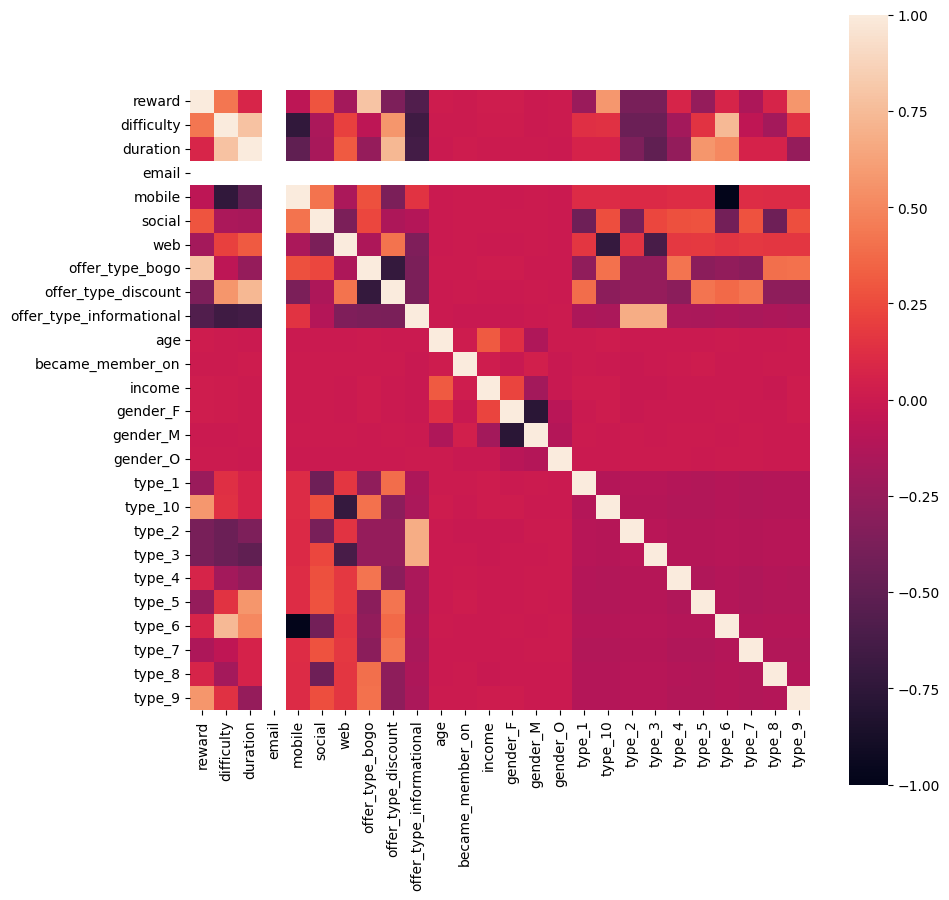

In [58]:
# Checking correlation between features
plt.figure(figsize=(10,10))
sns.heatmap(X.corr(), square=True);

In [59]:
# Email feature correlates with all other features, it's safe to remove this feature without impact to result
X = X.drop(['email'], axis=1)

In [60]:
# Split data to train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [61]:
# Set default params for our model
model = LogisticRegression(solver='liblinear', random_state=42)

In [62]:
# Train model
model.fit(X_train, y_train)

LogisticRegression(random_state=42, solver='liblinear')

In [63]:
lr_pred = model.predict(X_test)

In [64]:
lr_accuracy = accuracy_score(y_test, lr_pred)
lr_f1_score = f1_score(y_test, lr_pred)
print('LR Accuracy: %.3f' % accuracy_score(y_test, lr_pred))
print('LR F1-Score: %.3f' % lr_f1_score)

LR Accuracy: 0.760
LR F1-Score: 0.775


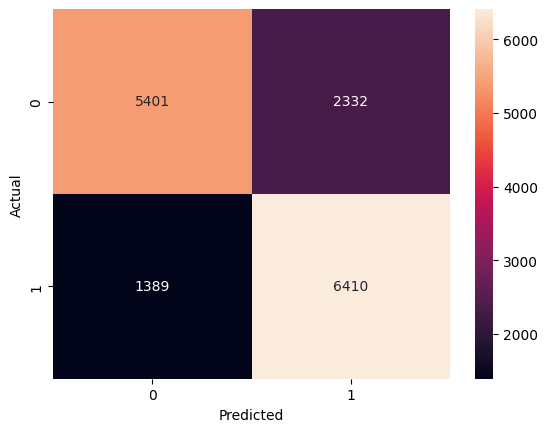

In [65]:
sns.heatmap(confusion_matrix(y_test, lr_pred), annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted');

In [66]:
# Tunning parameter using GridSearchCV
parameters = {'penalty': ['l1','l2'], 'C': [1, 10,100,1000]}
grid_log = GridSearchCV(LogisticRegression(), parameters, verbose=2, n_jobs=-1, cv=3)

In [67]:
grid_log.fit(X_train,y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] END ....................................C=1, penalty=l1; total time=   0.0s
[CV] END ...................................C=10, penalty=l1; total time=   0.0s
[CV] END ....................................C=1, penalty=l1; total time=   0.0s
[CV] END ....................................C=1, penalty=l1; total time=   0.0s
[CV] END ...................................C=10, penalty=l1; total time=   0.0s
[CV] END ...................................C=10, penalty=l2; total time=   0.3s
[CV] END ....................................C=1, penalty=l2; total time=   0.3s
[CV] END ..................................C=100, penalty=l1; total time=   0.0s
[CV] END ...................................C=10, penalty=l1; total time=   0.0s
[CV] END ..................................C=100, penalty=l1; total time=   0.0s
[CV] END ....................................C=1, penalty=l2; total time=   0.2s
[CV] END ..................................C=100,

/home/pqt/udacity_nd025/.venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
12 fits failed out of a total of 24.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "/home/pqt/udacity_nd025/.venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/pqt/udacity_nd025/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1091, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/pqt/udacity_nd025/.venv/lib/python3.10/site-packages/sklearn/linear_model/_log

GridSearchCV(cv=3, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [1, 10, 100, 1000], 'penalty': ['l1', 'l2']},
             verbose=2)

In [68]:
grid_log.best_params_

{'C': 100, 'penalty': 'l2'}

In [69]:
lr_2_pred = grid_log.predict(X_test)

In [70]:
log2_accuracy = accuracy_score(y_test, lr_2_pred)
log2_f1 = f1_score(y_test, lr_2_pred)

In [71]:
print('LR-CV Accuracy: %.3f' % log2_accuracy)
print('LR-CV F1-Score: %.3f' % log2_f1)

LR-CV Accuracy: 0.761
LR-CV F1-Score: 0.775


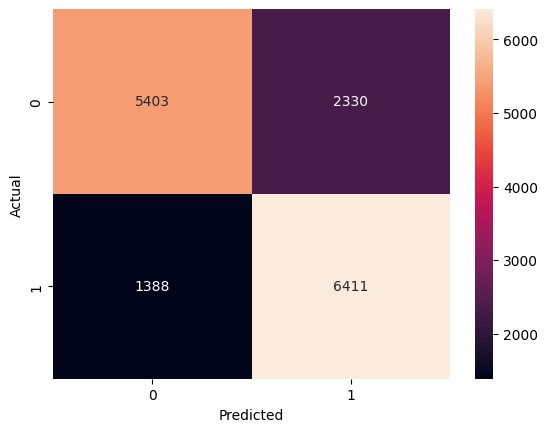

In [72]:
sns.heatmap(confusion_matrix(y_test, lr_2_pred), annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted');

### SVM

In [73]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=.2)
scaler = StandardScaler()
# Feature Scaling
X_train = preprocessing.scale(X_train)
X_test = preprocessing.scale(X_test)

In [74]:
# Init model using Linear
svc = SVC(kernel='linear')
# Train model
svc.fit(X_train, y_train)
# Predict
svc_pred = svc.predict(X_test)

In [75]:
svc_accuracy = accuracy_score(y_test, svc_pred)
svc_f1 = f1_score(y_test, svc_pred)
print('SVC Accuracy: %.3f' % svc_accuracy)
print('SVC F1-Score: %.3f' % svc_f1)

SVC Accuracy: 0.737
SVC F1-Score: 0.775


In [76]:
print(classification_report(y_test, svc_pred))

              precision    recall  f1-score   support

         0.0       0.85      0.57      0.68      7733
         1.0       0.68      0.90      0.78      7799

    accuracy                           0.74     15532
   macro avg       0.77      0.74      0.73     15532
weighted avg       0.77      0.74      0.73     15532



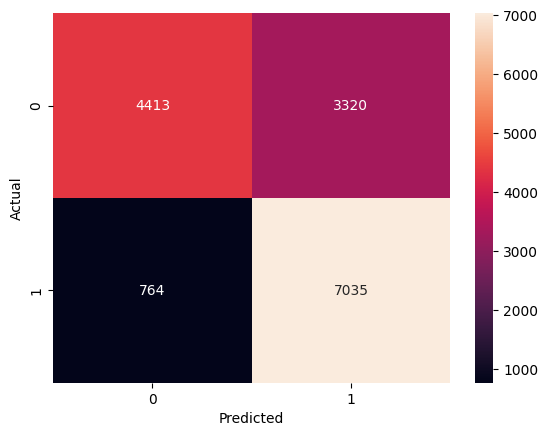

In [77]:
sns.heatmap(confusion_matrix(y_test, svc_pred), annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted');

In [78]:
# Init model using Radial Basic Function
svc = SVC(C=1, gamma='auto', kernel='rbf')
# Train model
svc.fit(X_train, y_train)
# Predict
svc_pred_2 = svc.predict(X_test)

In [79]:
svc_rbf_accuracy = accuracy_score(y_test, svc_pred_2)
svc_rbf_f1 = f1_score(y_test, svc_pred_2)
print('SVC Accuracy: %.3f' % svc_rbf_accuracy)
print('SVC F1-Score: %.3f' % svc_rbf_f1)

SVC Accuracy: 0.771
SVC F1-Score: 0.789


In [80]:
print(classification_report(y_test, svc_pred_2))

              precision    recall  f1-score   support

         0.0       0.82      0.69      0.75      7733
         1.0       0.73      0.85      0.79      7799

    accuracy                           0.77     15532
   macro avg       0.78      0.77      0.77     15532
weighted avg       0.78      0.77      0.77     15532



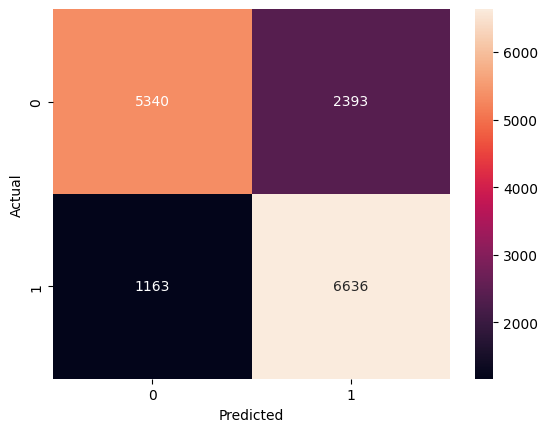

In [81]:
sns.heatmap(confusion_matrix(y_test, svc_pred_2), annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted');

In [82]:
# Init model using Radial Basic Function
svc = SVC(C=100, gamma=1, kernel='rbf', cache_size=600)
# Train model
svc.fit(X_train, y_train)
# Predict
svc_pred_3 = svc.predict(X_test)

In [83]:
svc_rbf_custom_accuracy = accuracy_score(y_test, svc_pred_3)
svc_rbf_custom_f1 = f1_score(y_test, svc_pred_3)
print('SVC Custom Accuracy: %.3f' % svc_rbf_custom_accuracy)
print('SVC Custom F1-Score: %.3f' % svc_rbf_custom_f1)

SVC Custom Accuracy: 0.788
SVC Custom F1-Score: 0.799


In [85]:
print(classification_report(y_test, svc_pred_3))

              precision    recall  f1-score   support

         0.0       0.82      0.73      0.77      7733
         1.0       0.76      0.84      0.80      7799

    accuracy                           0.79     15532
   macro avg       0.79      0.79      0.79     15532
weighted avg       0.79      0.79      0.79     15532



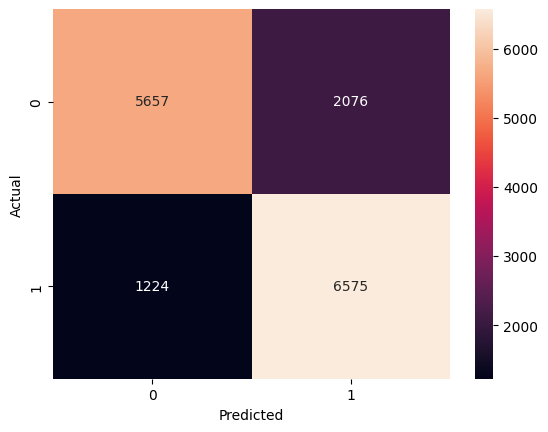

In [84]:
sns.heatmap(confusion_matrix(y_test, svc_pred_3), annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted');